### Fine Tuning Task  

강아지, 머핀 이진 분류  
https://drive.google.com/file/d/1Q_KC2nTmGlX2PeINWwV63_kpTjnoVpiO/view?usp=sharing

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/muffin/original/'

idg = ImageDataGenerator(rescale=1./255)

generator = idg.flow_from_directory(root, target_size=(64, 64), batch_size=32, class_mode='categorical')
print(generator.class_indices)

Found 4733 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}


In [2]:
target_name = {v: k for k, v in generator.class_indices.items()}
target_name

{0: 'chihuahua', 1: 'muffin'}

In [3]:
target_names = []
for target in generator.classes:
    target_names.append(target_name[target])

In [7]:
import pandas as pd

n_df = pd.DataFrame({'file_paths': generator.filepaths, 'target_names': target_names, 'targets': generator.classes})
n_df.file_paths = n_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
n_df

,file_paths,target_names,targets
0,./datasets/muffin/original/chihuahua/img_0_0.jpg,chihuahua,0
1,./datasets/muffin/original/chihuahua/img_0_1.jpg,chihuahua,0
2,./datasets/muffin/original/chihuahua/img_0_10.jpg,chihuahua,0
3,./datasets/muffin/original/chihuahua/img_0_100...,chihuahua,0
4,./datasets/muffin/original/chihuahua/img_0_100...,chihuahua,0
...,...,...,...
4728,./datasets/muffin/original/muffin/img_4_984.jpg,muffin,1
4729,./datasets/muffin/original/muffin/img_4_990.jpg,muffin,1
4730,./datasets/muffin/original/muffin/img_4_995.jpg,muffin,1
4731,./datasets/muffin/original/muffin/img_4_998.jpg,muffin,1


In [8]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = \
train_test_split(n_df.file_paths, 
                 n_df.targets, 
                 stratify=n_df.targets, 
                 test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
0    2047
1    1739
Name: count, dtype: int64
targets
0    512
1    435
Name: count, dtype: int64


In [9]:
train_df = n_df.iloc[train_images.index].reset_index(drop=True)
validation_df = n_df.iloc[validation_images.index].reset_index(drop=True)


train, validation split

In [10]:
print(train_df.shape)
print(validation_df.shape)

(3786, 3)
(947, 3)


test df 생성

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

root = './datasets/muffin/test/'

idg_test = ImageDataGenerator(rescale=1./255)

generator_test = idg.flow_from_directory(root, target_size=(64, 64), batch_size=32, class_mode='categorical')
print(generator_test.class_indices)

Found 1184 images belonging to 2 classes.
{'chihuahua': 0, 'muffin': 1}


In [12]:
target_name = {v: k for k, v in generator_test.class_indices.items()}
target_name

{0: 'chihuahua', 1: 'muffin'}

In [15]:
target_names = []
for target in generator_test.classes:
    target_names.append(target_name[target])

In [16]:
import pandas as pd

test_df = pd.DataFrame({'file_paths': generator_test.filepaths, 'target_names': target_names, 'targets': generator_test.classes})
test_df.file_paths = test_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))
test_df

,file_paths,target_names,targets
0,./datasets/muffin/test/chihuahua/img_0_1071.jpg,chihuahua,0
1,./datasets/muffin/test/chihuahua/img_0_1074.jpg,chihuahua,0
2,./datasets/muffin/test/chihuahua/img_0_1082.jpg,chihuahua,0
3,./datasets/muffin/test/chihuahua/img_0_1087.jpg,chihuahua,0
4,./datasets/muffin/test/chihuahua/img_0_11.jpg,chihuahua,0
...,...,...,...
1179,./datasets/muffin/test/muffin/img_4_979.jpg,muffin,1
1180,./datasets/muffin/test/muffin/img_4_989.jpg,muffin,1
1181,./datasets/muffin/test/muffin/img_4_991.jpg,muffin,1
1182,./datasets/muffin/test/muffin/img_4_996.jpg,muffin,1


In [17]:
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(3786, 3)
(947, 3)
(1184, 3)


In [18]:
import numpy as np
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2

IMAGE_SIZE = 64
BATCH_SIZE = 64

class Dataset(Sequence):
    def __init__(self, file_paths, targets, batch_size=BATCH_SIZE, aug=None, preprocess=None, shuffle=False):
        self.file_paths = file_paths
        self.targets = targets
        self.batch_size = batch_size
        self.aug = aug
        self.preprocess = preprocess
        self.shuffle = shuffle

        if self.shuffle:
            # 에포크 종료 시, 객체 생성 및 데이터 섞기
            self.on_epoch_end()

    # __len__()는 전체 데이터 건수에서 batch_size 단위로 나눈 데이터 수
    # 예를 들어, 1000개의 데이터를 30 batch_size로 설정하면, 1 batch당 33.33..개이다.
    # 이 때, 소수점은 무조건 올려서 33 + 1 = 34개로 설정한다.
    def __len__(self):
        return int(np.ceil(len(self.targets) / self.batch_size))

    # batch_size 단위로 이미지 배열과 타켓 데이터들을 가져온 뒤 변환한 값을 리턴한다.
    def __getitem__(self, index):
        file_paths_batch = self.file_paths[index * self.batch_size: (index + 1) * self.batch_size]
        targets_batch = self.targets[index * self.batch_size: (index + 1) * self.batch_size]

        results_batch = np.zeros((file_paths_batch.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

        for i in range(file_paths_batch.shape[0]):
            image = cv2.cvtColor(cv2.imread(file_paths_batch[i]), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

            if self.aug is not None:
                image = self.aug(image=image)['image']

            if self.preprocess is not None:
                image = self.preprocess(image)
                    
            results_batch[i] = image

        return results_batch, targets_batch
        
    def on_epoch_end(self):
        if self.shuffle:
            self.file_paths, self.targets = shuffle(self.file_paths, self.targets)        

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

def create_model(model_name='vgg16', verbose=False):
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50': # ResNet50, 74.9% ; ResNet50V2, 76.0%
        model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception': # Inception을 기초로 한 모델
        model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'mobilenet':
        model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

    x = model.output

    # 분류기
    x = GlobalAveragePooling2D()(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    output = Dense(2, activation='softmax', name='output')(x)
    
    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
    
    return model

In [21]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='mobilenet', verbose=True)
# model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['acc'])
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

C:\Users\kangh\AppData\Local\Temp\ipykernel_18204\108774744.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 32, 32, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 32, 32, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 32, 32, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 32, 32, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 32, 32, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 32, 32, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 32, 32, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 32, 32, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 32, 32, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 32, 32, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 32, 32, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 33, 33, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 16, 16, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,136 (8.86 MB)

 Trainable params: 2,288,024 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [22]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import layers

IMAGE_SIZE = 64
BATCH_SIZE = 64

def fine_tune(datas, model_name, aug, preprocess):
    FIRST_EPOCHS = 10
    SECOND_EPOCHS = 10
    
    train_filee_paths, train_targets, \
    validation_file_paths, validation_targets, \
    test_file_paths, test_targets = datas

    train_dataset = Dataset(train_file_paths, 
                        train_targets, 
                        batch_size=BATCH_SIZE, 
                        aug=aug, 
                        preprocess=xception_preprocess_input, 
                        shuffle=True)

    validation_dataset = Dataset(validation_file_paths, 
                            validation_targets, 
                            batch_size=BATCH_SIZE, 
                            preprocess=xception_preprocess_input)
    
    model = create_model(model_name=model_name, verbose=True)
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

    # feature extractor layer들을 전부 freeze
    for layer in model.layers[:-5]:
        layer.trainable = False

    model.fit(train_dataset,
              batch_size=BATCH_SIZE,
              epochs = FIRST_EPOCHS,
              validation_data=validation_dataset)

    # 배치 정규화만 freeze 진행
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    # 부분 freeze 진행 (위에 복붙한다음 개수 헤아려서 직접 넣어주면됨)
    model. compile(optimizer=Adam(0.00001), loss=CategoricalCrossentropy(), metrics=['acc'])
    history = model.fit(train_dataset,
                       batch_size=BATCH_SIZE,
                       epochs=SECOND_EPOCHS,
                       validation_data=validation_dataset)

    return model, history

In [25]:
import albumentations as A
from tensorflow.keras.applications.mobilenet import preprocess_input as mobilenet_preprocess_input

train_file_paths = train_df['file_paths'].values
# train_targets = train_df['targets'].values # SparseCategoricalCrossEntropy
train_targets = pd.get_dummies(train_df['targets']).values # CategoricalCrossEntropy

validation_file_paths = validation_df['file_paths'].values
# validation_targets = validation_df['targets'].values # SparseCategoricalCrossEntropy
validation_targets = pd.get_dummies(validation_df['targets']).values # CategoricalCrossEntropy

test_file_paths = test_df['file_paths'].values
# test_targets = test_df['targets'].values # SparseCategoricalCrossEntropy
test_targets = pd.get_dummies(test_df['targets']).values # CategoricalCrossEntropy

aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CenterCrop(height=64, width=64, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

model, history = fine_tune((train_file_paths, train_targets,
          validation_file_paths, validation_targets,
          test_file_paths, test_targets),
         'mobilenet',
          aug,
          mobilenet_preprocess_input)


C:\Users\kangh\AppData\Local\Temp\ipykernel_18204\108774744.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 32, 32, 32)        │             864 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 32, 32, 32)        │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 32, 32, 32)        │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 32, 32, 32)        │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 32, 32, 32)        │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 32, 32, 32)        │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 32, 32, 16)        │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 32, 32, 16)        │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 32, 32, 96)        │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 32, 32, 96)        │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 32, 32, 96)        │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 33, 33, 96)        │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 16, 16, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,322,136 (8.86 MB)

 Trainable params: 2,288,024 (8.73 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 392ms/step - acc: 0.7282 - loss: 0.7611 - val_acc: 0.9419 - val_loss: 0.1689
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - acc: 0.8862 - loss: 0.2635 - val_acc: 0.9366 - val_loss: 0.1572
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - acc: 0.9024 - loss: 0.2325 - val_acc: 0.9430 - val_loss: 0.1509
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 364ms/step - acc: 0.9056 - loss: 0.2293 - val_acc: 0.9504 - val_loss: 0.1498
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - acc: 0.9177 - loss: 0.2014 - val_acc: 0.9461 - val_loss: 0.1426
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - acc: 0.9099 - loss: 0.1989 - val_acc: 0.9504 - val_loss: 0.1383
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 364ms/step - acc: 0.9194 - loss: 0.1975 - val_acc: 0.9556 - val_loss: 0.1355
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - acc: 0.9245 - loss: 0.1843 - val_acc: 0.9525 - val_loss: 0.1315
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 353ms/step - acc:

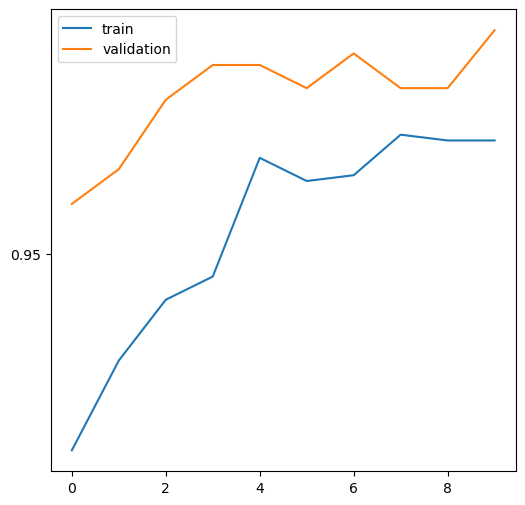

In [27]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6,6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()

show_history(history)

In [29]:
model.evaluate(generator_test)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - acc: 0.9567 - loss: 0.1030


[0.11305155605077744, 0.9543918967247009]

In [59]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import MobileNet, decode_predictions


def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')

def get_prediction_from_generator(image, image_size=(64, 64)):
    image = cv2.resize(image, image_size)
    image = img_to_array(image)
    
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)

    # print(prediction)
    # print(target_name)
    for i, prediction in enumerate(prediction):
        print(i, prediction)
        predicted_class_index = np.argmax(prediction)
        predicted_class_label = target_name[predicted_class_index]
    
    return predicted_class_label

def get_prediction_from_web(image):
    
    image = img_to_array(image)
    
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)

    # print(prediction)
    # print(target_name)
    for i, prediction in enumerate(prediction):
        print(i, prediction)
        predicted_class_index = np.argmax(prediction)
        predicted_class_label = target_name[predicted_class_index]
    
    return predicted_class_label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
0 [0.44960427 0.5503957 ]


'muffin'

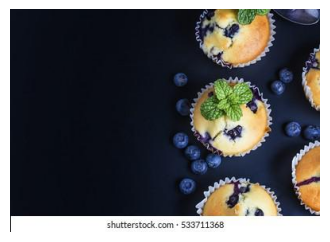

In [89]:
import cv2
import matplotlib.pyplot as plt

# rgb한장 가져와서 보기
image = cv2.cvtColor(cv2.imread(generator_test.filepaths[1140]), cv2.COLOR_BGR2RGB)
show_image(image)
get_prediction_from_generator(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
0 [0.9728256  0.02717435]


'chihuahua'

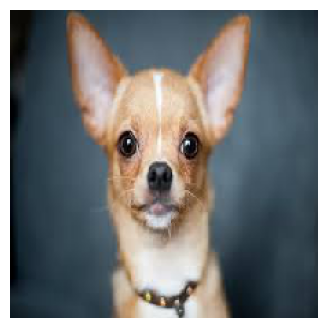

In [57]:
image = load_img('./datasets/chihuahua.jpg', target_size=(224, 224))
show_image(image)
get_prediction_from_web(image)